Before rerunning this analysis, make a copy of this file. 

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import utils
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pyspark.sql import SparkSession
import os

os.environ['TZ'] = 'UTC'

# Read from S3

After the data has been collected, the dataset size is relatively small with significant reduction over scraped dataset.

In [ ]:
cfg_file = utils.findConfig()
cfg = utils.parseConfig(cfg_file)
spark = (
  SparkSession
  .builder
  .appName('redditData')
  .config('spark.driver.extraJavaOptions', '-Duser.timezone=GMT') 
  .config('spark.executor.extraJavaOptions', '-Duser.timezone=GMT')
  .config('spark.sql.session.timeZone', 'UTC')
  .config("fs.s3a.access.key", cfg['ACCESSKEY'])
  .config("fs.s3a.secret.key", cfg['SECRETKEY'])
  .getOrCreate()
)
df = spark.read.parquet('s3a://data-kennethmyers/redditAggregatedData.parquet').toPandas()

# Distributions

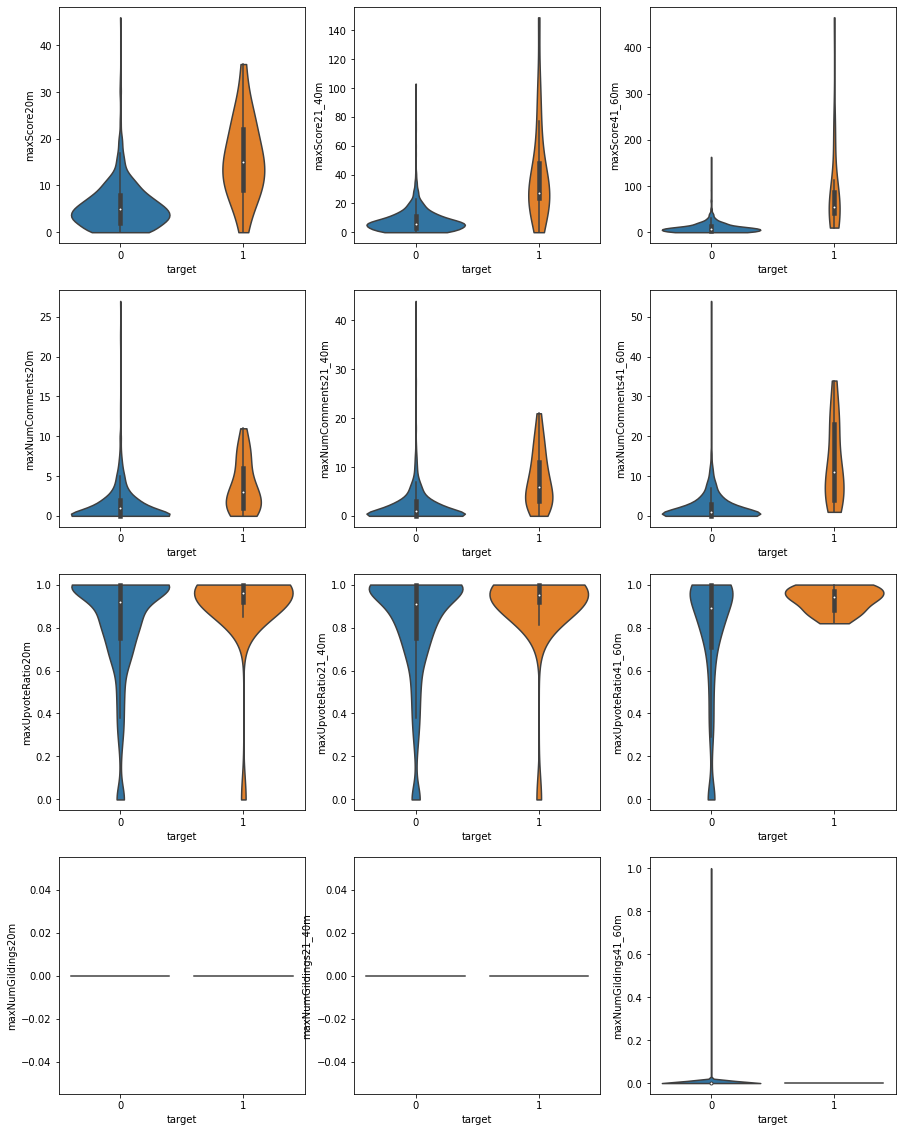

In [ ]:
df = df.fillna(0)

featureColumns = df.columns[4:-1]
featureColumns = np.array(featureColumns).reshape(4,3)

fig, axes = plt.subplots(4, 3, figsize=(15, 20), sharey=False)

for i,row in enumerate(featureColumns):
  for j,col in enumerate(row):
    sns.violinplot(data = df, x='target', y=col, ax=axes[i,j], cut=0)
    
plt.show()

- It looks like the maxScore could be one of the best features.
- numComments could also be predictive, looks like there is good mean separation, although the extremes of non-viral have high comment counts.
- maxUpvotedRatio is at later times seems like it could be predictive but not at the lower end.
- numGildings will probably be one of the weakest, it's generally constant (0).

# Describe features

In [ ]:
for col in df.columns[4:-1]:
  print(col)
  subdf = df[[col, 'target']].groupby('target').describe()
  print(subdf.reset_index(drop=False).to_string())
  print()

maxScore20m
  target maxScore20m                                                 
               count       mean       std  min  25%   50%   75%   max
0      0       931.0   5.622986  4.879480  0.0  2.0   5.0   8.0  46.0
1      1        25.0  15.800000  8.519585  0.0  9.0  15.0  22.0  36.0

maxScore21_40m
  target maxScore21_40m                                                    
                  count       mean        std  min   25%   50%   75%    max
0      0          931.0   8.254565   8.546562  0.0   3.0   6.0  11.0  103.0
1      1           25.0  40.120000  33.870243  0.0  24.0  27.0  48.0  149.0

maxScore41_60m
  target maxScore41_60m                                                     
                  count       mean        std   min   25%   50%   75%    max
0      0          931.0  10.307197  11.912050   0.0   3.0   8.0  14.0  163.0
1      1           25.0  87.720000  98.696724  10.0  42.0  54.0  87.0  465.0

maxNumComments20m
  target maxNumComments20m                   

# Hour of Day

Although post count is low right now, what does hour of day look like for virality

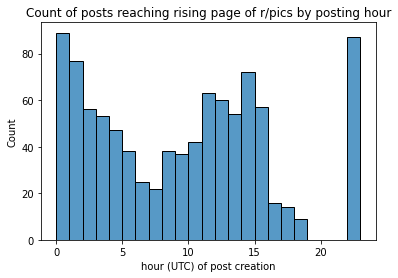

In [ ]:
sns.histplot(df['createdTSUTC'].apply(lambda x: x.hour), binwidth=1)
plt.xlabel('hour (UTC) of post creation')
plt.title('Count of posts reaching rising page of r/pics by posting hour')
plt.show()

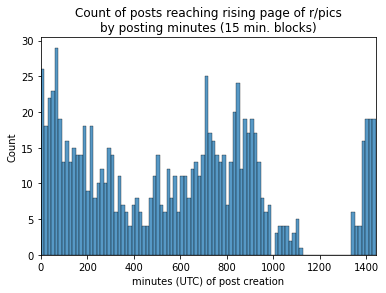

In [ ]:
# this is just a higher resolution of the above plot, you can change the bin with to however many minutes
blockSize = 15
sns.histplot(df['createdTSUTC'].apply(lambda x: x.hour*60+x.minute), binwidth=blockSize)
plt.xlim(0,60*24)
plt.xlabel('minutes (UTC) of post creation')
plt.title(f'Count of posts reaching rising page of r/pics\nby posting minutes ({blockSize} min. blocks)')
plt.show()

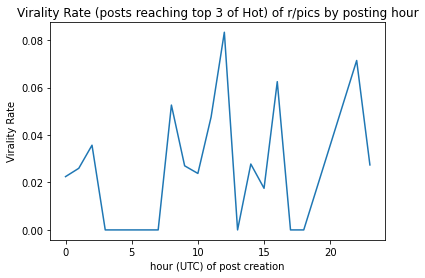

In [ ]:
df['hour'] = df['createdTSUTC'].apply(lambda x: x.hour)
viralityByHour = df[['hour', 'target']].groupby('hour').mean().reset_index(drop=False)
x = viralityByHour['hour']
y = viralityByHour['target']
plt.plot(x,y)
plt.xlabel('hour (UTC) of post creation')
plt.title('Virality Rate (posts reaching top 3 of Hot) of r/pics by posting hour')
plt.ylabel('Virality Rate')
plt.show()

These insights are really fascinating so far but would probably warrant a second glance when more data is available. We can see that posts never even make it to rising if posted around 3-6pm EST. My guess is that there is such an influx of content from kids getting out of school and people getting off of work that nothing posted in this region makes it to rising. As such, it could be good to have encode a flag designating these hours. 

It's also interesting to see that right now 8% of posts made at 8am go viral, with some other peaks at about 12pm and 6pm. This is still very noisy and I think more data needs to be collected before we can draw anything conclusive about these hours.